In [17]:
from analyzer import Analyzer, TestSubject
import sklearn
import json
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import math

Setting Up TEST_SUBJECTS

In [18]:
control_start = datetime.datetime(year=2022, month=12, day=1)
control_end   = datetime.datetime(year=2022, month=12, day=3)

variant_start = datetime.datetime(year=2022, month=12, day=3)
variant_end   = datetime.datetime(year=2022, month=12, day=5)

control_subject = TestSubject(name="A", tested_from=control_start, tested_till=control_end, item_name="Apple", item_x = 1.4, item_y= 0.2)
variant_subject = TestSubject(name="B", tested_from=variant_start, tested_till=variant_end, item_name="Apple", item_x = 1.4, item_y= 0.2)

print(control_subject.to_string())
print(variant_subject.to_string())

do_use_fake_distribution = True

A:
Test Period : 2022/12/01 00:00:00 ~ 2022/12/03 00:00:00
Target Item : Apple
 Located At : 1.4, 0.2
B:
Test Period : 2022/12/03 00:00:00 ~ 2022/12/05 00:00:00
Target Item : Apple
 Located At : 1.4, 0.2


LOADING DATAS

In [19]:
df_face_count = pd.read_json("aws_get_data/test_face_count_data.json")
df_local_data = pd.read_json("aws_get_data/test_local_data.json")
df_point_of_sale = pd.read_json("aws_get_data/test_point_of_sales_data.json")

print(df_face_count.head(5))
print(df_local_data.head(5))
print(df_point_of_sale.head(5))

   facecount  device_id      date   time                sample_time
0          1          0  20221201  14952 1970-08-23 01:00:01.014953
1          2          0  20221201  15308 1970-08-23 01:00:01.015309
2          1          0  20221201  15644 1970-08-23 01:00:01.015645
3          0          0  20221201  15539 1970-08-23 01:00:01.015551
4          1          0  20221201  15749 1970-08-23 01:00:01.015749
       y      date  user_id    time      x
0 -0.860  20221201    11143  103834  0.562
1 -0.438  20221201    11143  103840  1.348
2 -0.438  20221201    11143  103845  1.348
3 -0.286  20221201    11143  103849  1.403
4 -0.286  20221201    11143  103853  1.403
   count      date product_name    price  product_id market_name
0     14  20221201        Apple  1250000       11343   iPhone 14
1      2  20221202        Apple  1250000       11343   iPhone 14
2      5  20221203        Apple  1250000       11343   iPhone 14
3      8  20221204        Apple  1250000       11343   iPhone 14


In [20]:
my_analyzer = Analyzer([control_subject, variant_subject], df_point_of_sale, df_local_data, df_face_count)


[   count      date product_name    price  product_id market_name name
0     14  20221201        Apple  1250000       11343   iPhone 14    A
1      2  20221202        Apple  1250000       11343   iPhone 14    A,    count      date product_name    price  product_id market_name name
2      5  20221203        Apple  1250000       11343   iPhone 14    B
3      8  20221204        Apple  1250000       11343   iPhone 14    B]
       y      date  user_id    time      x name
0 -0.860  20221201    11143  103834  0.562    A
1 -0.438  20221201    11143  103840  1.348    A
2 -0.438  20221201    11143  103845  1.348    A
3 -0.286  20221201    11143  103849  1.403    A
4 -0.286  20221201    11143  103853  1.403    A
        y      date  user_id    time      x name
50 -0.860  20221203    23123  103834  0.562    B
51 -0.438  20221203    23123  103840  1.348    B
52 -0.438  20221203    23123  103845  1.348    B
53 -0.286  20221203    23123  103849  1.403    B
54 -0.286  20221203    23123  103853  1.403 

In [21]:
def show_distribution(
    distributions
):
    n_control= distributions[0]['n']
    n_variant= distributions[1]['n']
    mean_control= distributions[0]['mean']
    mean_variant= distributions[1]['mean']
    var_control = distributions[0]['var']
    var_variant = distributions[1]['var']
    std_control = math.sqrt(var_control)
    std_variant = math.sqrt(var_variant)

    plt.style.use('default')
    plt.style.use('ggplot')

    control_x = np.linspace(mean_control - 3*std_control, mean_control + 3*std_control, 100)

    fig, ax = plt.subplots(figsize=(7, 3.5))

    ax.plot(control_x, stats.norm.pdf(control_x, mean_control, std_control), 'red', label="Control")
    ax.plot(control_x, stats.norm.pdf(control_x, mean_variant, std_variant), 'green', label="Variant")
    #ax.scatter(z_score, y_true, edgecolor='k', facecolor='red', alpha=0.7, label='This week data')

    ax.legend()
    #ax.text(0.55, 0.15, '$mean = %.2f std =%.2f $' % (mean, std ), fontsize=17, transform=ax.transAxes)

    fig.tight_layout()
    plt.show()
    
    return


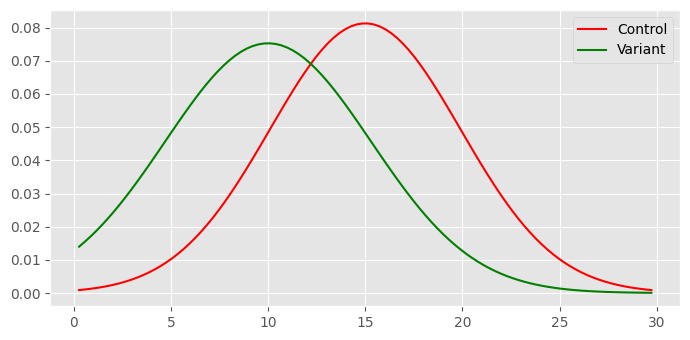

Z-Score : -19.968131931175947
p_value : 5.214057175849327e-89
Reject the Null Hypothesis ? : True


In [22]:
sale_distribution, z_score, p_value = my_analyzer.sale_analysis()

if do_use_fake_distribution:
    sale_distribution = [
        {
            "n" : 711,
            "mean" : 15,
            "var"  : 24.0931
        },
        {
            "n" : 975,
            "mean" : 10,
            "var"  : 28.0931
        }
    ]

    z_score = my_analyzer._z_score_two_distribution(
        n_control= sale_distribution[0]['n'],
        n_variant= sale_distribution[1]['n'],
        mean_control= sale_distribution[0]['mean'],
        mean_variant= sale_distribution[1]['mean'],
        var_control = sale_distribution[0]['var'],
        var_variant = sale_distribution[1]['var']
    )

    p_value = my_analyzer.p_value_from_z(z_score)

show_distribution(sale_distribution)

print(f"Z-Score : {z_score}\np_value : {p_value}")
print(f"Reject the Null Hypothesis ? : {my_analyzer.do_reject_null_hypothesis(p_value)}")

/home/iknow/Desktop/IoTProject/src/analyzer.py:313: RuntimeWarning: invalid value encountered in double_scalars
  z_score = s_mean / np.sqrt(s_var)


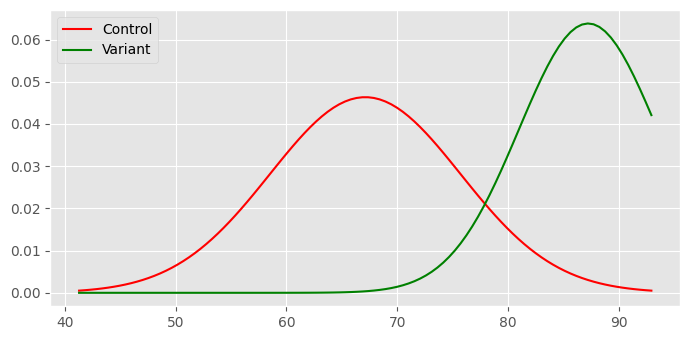

Z-Score : 52.96475871481975
p_value : 0.0
Reject the Null Hypothesis ? : True


In [23]:
time_spent_distribution, z_score, p_value = my_analyzer.time_spent_analysis()
if do_use_fake_distribution:
    time_spent_distribution = [
        {
            "n" : 711,
            "mean" : 67.11,
            "var"  : 74.0931
        },
        {
            "n" : 975,
            "mean" : 87.23,
            "var"  : 68.0931
        }
    ]

    z_score = my_analyzer._z_score_two_distribution(
        n_control= time_spent_distribution[0]['n'],
        n_variant= time_spent_distribution[1]['n'],
        mean_control= time_spent_distribution[0]['mean'],
        mean_variant= time_spent_distribution[1]['mean'],
        var_control = time_spent_distribution[0]['var'],
        var_variant = time_spent_distribution[1]['var']
    )

    p_value = my_analyzer.p_value_from_z(z_score)
show_distribution(time_spent_distribution)

print(f"Z-Score : {z_score}\np_value : {p_value}")
print(f"Reject the Null Hypothesis ? : {my_analyzer.do_reject_null_hypothesis(p_value)}")

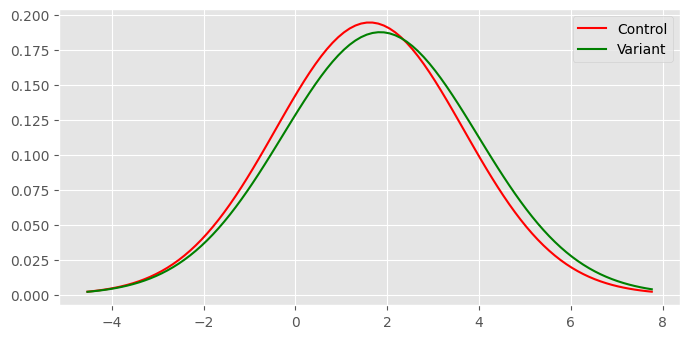

Z-Score : 1.232570139336592
p_value : 0.10886809167516259
Reject the Null Hypothesis ? : False


In [24]:
face_count_distribution, z_score, p_value = my_analyzer.face_count_analysis()
if do_use_fake_distribution:
    time_spent_distribution = [
        {
            "n" : 711,
            "mean" : 3.787,
            "var"  : 74.0931
        },
        {
            "n" : 975,
            "mean" : 4.24,
            "var"  : 30.0931
        }
    ]

    z_score = my_analyzer._z_score_two_distribution(
        n_control= time_spent_distribution[0]['n'],
        n_variant= time_spent_distribution[1]['n'],
        mean_control= time_spent_distribution[0]['mean'],
        mean_variant= time_spent_distribution[1]['mean'],
        var_control = time_spent_distribution[0]['var'],
        var_variant = time_spent_distribution[1]['var']
    )

    p_value = my_analyzer.p_value_from_z(z_score)

show_distribution(face_count_distribution)

print(f"Z-Score : {z_score}\np_value : {p_value}")
print(f"Reject the Null Hypothesis ? : {my_analyzer.do_reject_null_hypothesis(p_value)}")